# 1. Gather Data
#### Convert the Imgs Text to actual text for pre-processing


Pytesseract docs: [link](https://pytesseract.readthedocs.io/en/latest/) <br>
Pytesseract PSM [link](https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/) <br>
Pillow docs: [link](https://pillow.readthedocs.io/en/stable/)


In [2]:
%pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import os
import nltk
import json
from nltk.corpus import words
import matplotlib.pyplot as plt

nltk.download('words')

def filter_text(text):
    # print(text)
    # all_letters = set(string.ascii_letters)
    # text_letters = set(filter(str.isalpha, text))
    cleaned_text = text.replace('\n', '').replace('\f', '')
    return cleaned_text

def preprocess_image(image):
    # Apply sharpen and smooth filters
    image = image.filter(ImageFilter.SHARPEN)
    image = image.filter(ImageFilter.SMOOTH_MORE)

    # Increase DPI (dots per inch)
    image.info['dpi'] = (800, 800)

    return image

def enhance_contrast(image, factor):
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(factor)
    return enhanced_image

def process_and_detect_word_art(image_path, sentences_set,labels_list, contrast_factor=10.0):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Preprocess the image
    image = preprocess_image(image)

    # Enhance contrast
    image = enhance_contrast(image, contrast_factor)

    PSM_MODES:list = [3, 6, 7, 9]
    for psm in PSM_MODES:
        custom_config = f"--oem 3 --psm {psm}"
        text = pytesseract.image_to_string(image, config=custom_config)
        print(f"{image_path.split('/')[-1]} PSM Mode {psm} Output:")

        # ! Debugging: Display the image
        # plt.imshow(image)
        # plt.title(f"PSM Mode {psm} Output")
        # print(text)
        # plt.show()

        if filter_text(text):
            sentences_set.add(text)
            labels.append(psm)

# Define the directory containing your image files
DIR = '../data/imgs/'  # Update with the path to your DIR

# List all image files in the DIR
image_files = [file for file in os.listdir(DIR) if file.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

sentences_set = set()  # Set to store unique sentences
labels = list()  # Set to store unique sentences

# Process and detect word art for each image
for image_file in image_files:
    image_path = os.path.join(DIR, image_file)
    print(f"Processing: {image_path}")
    process_and_detect_word_art(image_path, sentences_set,labels)

# Write unique sentences to a single JSON file
output_json_filename = '../data/json/unique_sentences.json'
with open(output_json_filename, 'w') as json_file:
    cleaned_set = [s.replace('\n', '').replace('\f', '') for s in sentences_set]
    json.dump({"text": list(cleaned_set),"lables":labels}, json_file, indent=3)


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\retro\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Processing: ../data/imgs/Test_Capture_1.jpg


TesseractError: (1, "Tesseract Open Source OCR Engine v3.05.00dev with Leptonica read_params_file: Can't open 3 read_params_file: Can't open -psm read_params_file: Can't open 3 read_params_file: Can't open txt Warning in pixReadMemPng: work-around: writing to a temp file libpng warning: Application built with libpng-1.4.3 but running with 1.5.14 Error in pixReadStreamPng: png_ptr not made Error in pixReadMemPng: pix not read Error in pixReadMem: png: no pix returned Error during processing.")

# The Model Idea Copy Pasta

In [51]:
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import joblib
import json
from sklearn.model_selection import train_test_split

# Step 1: Load your textual data from a JSON file
json_filename = '../data/json/unique_sentences.json'
with open(json_filename, 'r') as json_file:
    data = json.load(json_file)

# Extract the advertisement texts from the JSON data
text_data = data['texts']


# Define sentiment labels: 0 for Not Effective, 1 for Somewhat Effective, 2 for Mildly Effective, 3 for Effective
labels = data['labels']  # Replace with actual sentiment labels

# Step 2: Set Parameters
max_words = 10000  # Maximum number of words in your vocabulary
max_sequence_length = 100  # Maximum length of input sequences
embedding_dim = 100  # Dimension of word embeddings
lstm_units = 64  # Number of LSTM units
dropout_rate = 0.2  # Dropout rate
num_classes = 4  # Number of sentiment classes

# Step 3: Text Tokenization and Padding
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

# Step 5: Define the LSTM Model
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

# Train the model with your data
# model.fit(X_train, y_train, epochs=YOUR_NUM_EPOCHS, validation_data=(X_test, y_test))

# Save the model as .h5 file
model.save("lstm_ad_sentiment_model.h5")

# Save the tokenizer as a .pkl file
joblib.dump(tokenizer, "tokenizer.pkl")

# Load the model and tokenizer for making predictions
loaded_model = load_model("lstm_ad_sentiment_model.h5")
loaded_tokenizer = joblib.load("tokenizer.pkl")

# Prepare new text for prediction
new_text = "A new advertisement text for analysis."

# Tokenize and pad the new text
new_text_sequence = loaded_tokenizer.texts_to_sequences([new_text])
new_text_padded = pad_sequences(new_text_sequence, maxlen=max_sequence_length)

# Make predictions
predictions = loaded_model.predict(new_text_padded)

# Interpret the predictions based on your sentiment class labels
# You can access predictions[0][0] to predictions[0][3] for the corresponding classes (0 to 3).


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           42240     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_1 (Dense)             (None, 100, 4)            260       
                                                                 
Total params: 1042500 (3.98 MB)
Trainable params: 1042500 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


c:\Users\athar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 680ms/step


# Data Collection 1

In [5]:
%pip install faker
%pip install pandas

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.6/1.7 MB 8.9 MB/s eta 0:00:01
   ---------------------- ----------------- 1.0/1.7 MB 10.5 MB/s eta 0:00:01
   ---------------------------------- ----- 1.5/1.7 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 10.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     ------------------------------------- 341.8/341.8 kB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.6 MB 10.9 MB/s eta 0:00:01
   ---- ----------------------------------- 1.1/10.6 MB 13.4 MB/s eta 0:00:01
   ------ --------------------------------- 1.6/10.6 MB 11.5 MB/s eta 0:00:01
   -------- ------------------------------- 2.2/10.6 MB 11.5 MB/s eta 0:00:01
   ---------- ---------

In [8]:
import pandas as pd
import random
from datetime import datetime, timedelta
from faker import Faker

# Create an empty DataFrame
data = pd.DataFrame(columns=['number', 'advertisement_text', 'time', 'review', 'sentiment'])

# Define the possible sentiments
sentiments = ['positive', 'negative']

# Start with number 5 (assuming you already have rows with numbers 1 to 4)
current_number = 5

# Create a Faker object for generating random text
fake = Faker()

# Generate 50 more rows of data
for _ in range(500):
    # Generate random data
    advertisement_text = fake.sentence()
    time = (datetime(2023, 11, 5, 10, 30, 0) + timedelta(minutes=current_number * 15)).strftime('%Y-%m-%d %H:%M:%S')
    review = random.choice(sentiments)
    review_text = fake.paragraph(nb_sentences=random.randint(1, 4))
    data.loc[len(data)] = [current_number, advertisement_text, time, review_text, review]
    
    current_number += 1

# Save the generated data to a CSV file
data.to_csv('../data/dataset/sample_data.csv', index=False)


# The Real Model Thought

In [10]:
%pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/65.5 kB ? eta -:--:--
     ---------------------------------------- 65.5/65.5 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
      --------------------------------------- 0.0/1.5 MB 1.4 MB/s eta 0:00:02
     -- ------------------------------------- 0.1/1.5 MB 1.2 MB/s eta 0:00:02
     ---- ----------------------------------- 0.2/1.5 MB 1.5 MB/s eta 0:00:01
     ------ --------------------------------- 0.2/1.5 MB 1.7 MB/s eta 0:00:01
     ------- -------------------------------- 0.3/1.5 MB 1.4 MB/s eta 0:00:01
     --------- ------------------------------ 0.4/1.5 MB 1.4 MB/s eta 0:00:01
     ---------- ----------------------------- 0.4/1.5 MB 1.4 MB/s eta 0:00:01
     ----------- ---------------------------- 0.4/1.5 MB 1.3 MB/s eta 0:00:01
 

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\projects\\Python Project\\.venv\\Lib\\site-packages\\clang\\native\\libclang.dll'
Check the permissions.



In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load your dataset from a CSV file (adjust the file path accordingly)
data = pd.read_csv('../data/dataset/sample_data.csv')

# Assuming the 'review' column contains text data and the 'sentiment' column contains sentiment labels ('positive' or 'negative')
texts = data['review'].values
sentiments = data['sentiment'].values

# Encode the sentiment labels
label_encoder = LabelEncoder()
sentiments_encoded = label_encoder.fit_transform(sentiments)
sentiments_one_hot = to_categorical(sentiments_encoded)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences to have the same length
max_sequence_length = 100  # Adjust as needed
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, sentiments_one_hot, test_size=0.2, random_state=42)

# Create a CNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='softmax'))  # Two output units for 'positive' and 'negative'

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

model.summary()


KeyboardInterrupt: 

# Summary

Epoch 1/5
7/7 [==============================] - 1s 77ms/step - loss: 0.4648 - accuracy: 0.9675 - val_loss: 0.6796 - val_accuracy: 0.5500
Epoch 2/5
7/7 [==============================] - 1s 86ms/step - loss: 0.3976 - accuracy: 0.9850 - val_loss: 0.6778 - val_accuracy: 0.5700
Epoch 3/5
7/7 [==============================] - 1s 80ms/step - loss: 0.3233 - accuracy: 0.9925 - val_loss: 0.6774 - val_accuracy: 0.5800
Epoch 4/5
7/7 [==============================] - 1s 85ms/step - loss: 0.2486 - accuracy: 0.9975 - val_loss: 0.6892 - val_accuracy: 0.5500
Epoch 5/5
7/7 [==============================] - 1s 86ms/step - loss: 0.1787 - accuracy: 0.9975 - val_loss: 0.7025 - val_accuracy: 0.5500


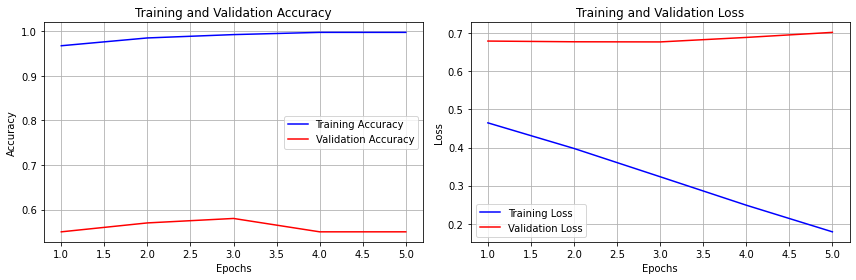

In [79]:
# Initialize lists to store training history
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Extract training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot performance graphs
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Testing

In [82]:
# Assuming you already have the trained model from the previous code
# Now, you can use the trained model to predict the sentiment of new text

# Replace 'your_text_here' with the text you want to analyze
new_text = ["Nice Place to visit and"]

# Tokenize and pad the new text
new_sequences = tokenizer.texts_to_sequences(new_text)
new_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Make predictions
predictions = model.predict(new_sequences)
print(predictions)
# Assuming a value close to 0 indicates negative sentiment and a value close to 1 indicates positive sentiment
if predictions[0][0] >= 0.5:
    print("Positive Sentiment")
else:
    print("Negative Sentiment")


1/1 [==============================] - 0s 50ms/step
[[0.29079112 0.7092089 ]]
Negative Sentiment
